<a href="https://colab.research.google.com/github/vimesh630/Spice_Price_Predction_VERGER/blob/Cinnamon/LightBGM_for_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Mount Google Drive and Import Required Libraries

In [16]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Load Data

In [17]:
file_path = "/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/Cinnamon_Dataset_Preprocessed_CrisisAware.csv"
df = pd.read_csv(file_path)

# Convert to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Ensure categorical
df['Grade'] = df['Grade'].astype('category')
df['Region'] = df['Region'].astype('category')

# Target & features
target = 'Regional_Price'
categorical_features = ['Grade', 'Region']
features = [col for col in df.columns if col not in [target, 'Month']]

# Sort by time
df = df.sort_values('Month').reset_index(drop=True)

#3. Time-Series Cross Validation

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 28.8839	valid_1's rmse: 568.98
[200]	training's rmse: 20.9572	valid_1's rmse: 563.215
[300]	training's rmse: 17.2103	valid_1's rmse: 561.68
[400]	training's rmse: 14.6927	valid_1's rmse: 560.67
Early stopping, best iteration is:
[355]	training's rmse: 15.6846	valid_1's rmse: 559.888


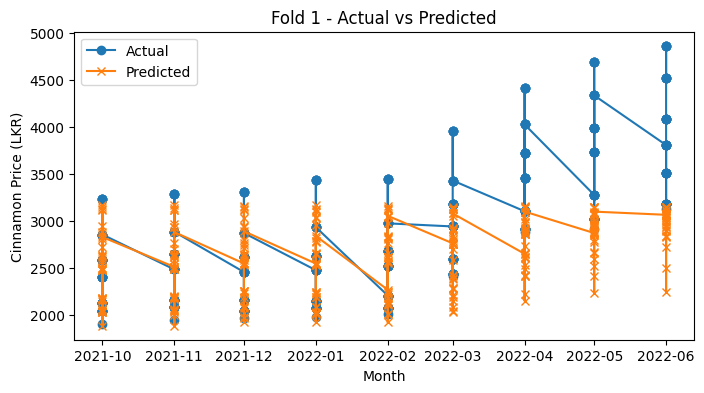

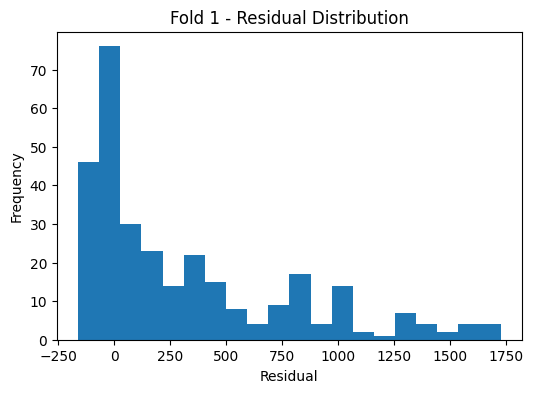


Fold 1 Results:
RMSE: 559.89 | MAE: 362.04 | R²: 0.4090 | MAPE: 10.04%
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 47.139	valid_1's rmse: 520.9
Early stopping, best iteration is:
[72]	training's rmse: 61.9682	valid_1's rmse: 519.37


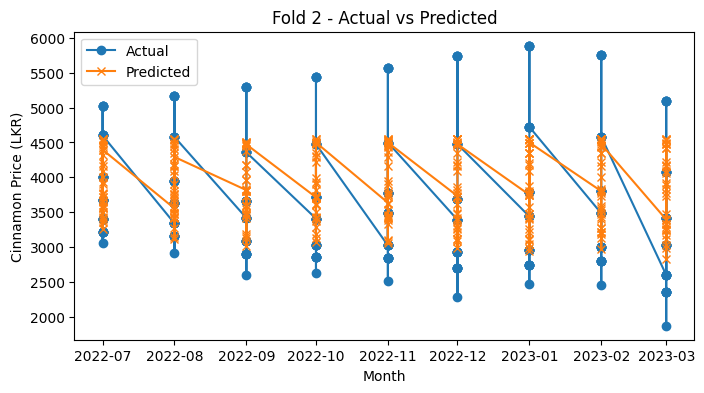

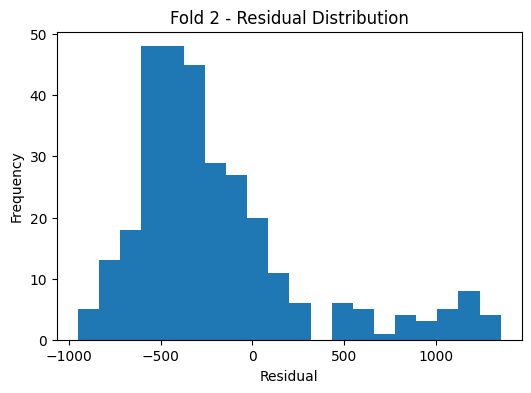


Fold 2 Results:
RMSE: 519.37 | MAE: 432.12 | R²: 0.6406 | MAPE: 12.31%
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's rmse: 178.925	valid_1's rmse: 188.035


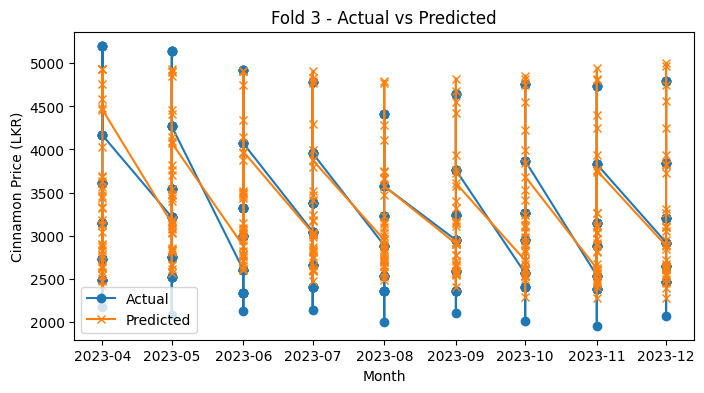

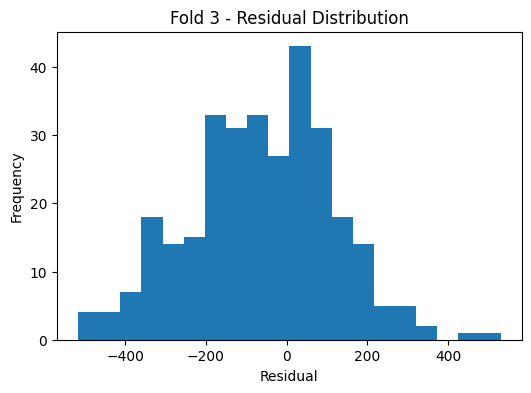


Fold 3 Results:
RMSE: 188.03 | MAE: 148.59 | R²: 0.9433 | MAPE: 5.02%
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 48.0545	valid_1's rmse: 143.656
Early stopping, best iteration is:
[73]	training's rmse: 68.0224	valid_1's rmse: 140.138


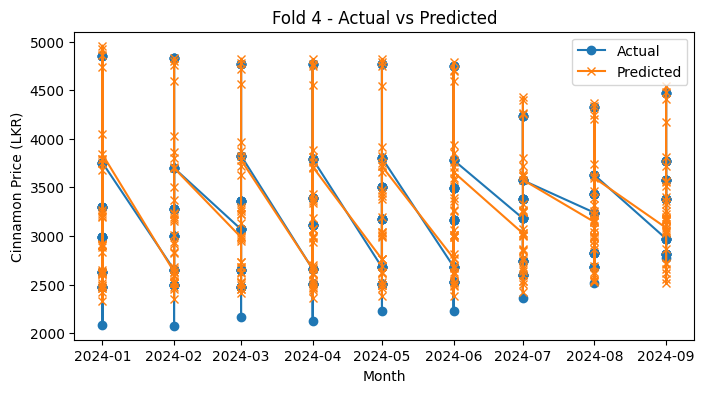

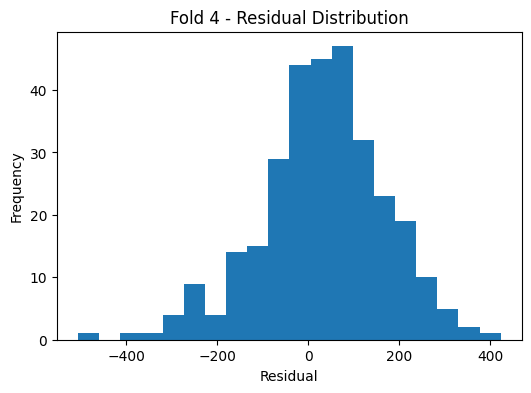


Fold 4 Results:
RMSE: 140.14 | MAE: 108.99 | R²: 0.9559 | MAPE: 3.43%
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 48.9679	valid_1's rmse: 178.307
Early stopping, best iteration is:
[123]	training's rmse: 40.5143	valid_1's rmse: 177.039


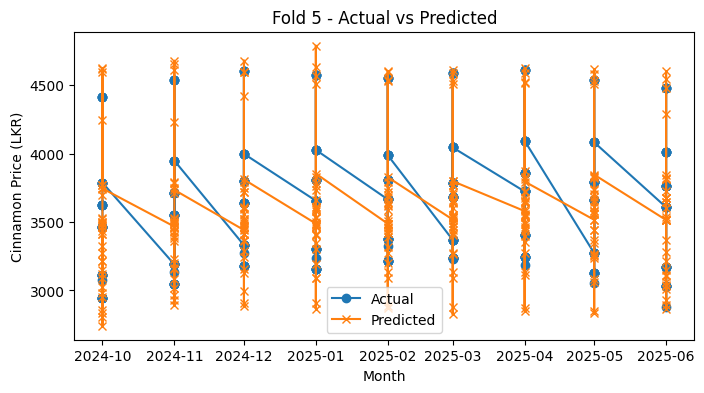

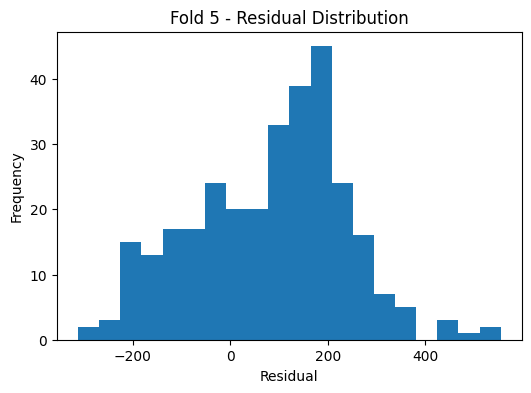


Fold 5 Results:
RMSE: 177.04 | MAE: 149.45 | R²: 0.8435 | MAPE: 4.14%


In [19]:
# Ensure categorical columns are correctly typed
categorical_features = ['Grade', 'Region', 'region_month', 'grade_region']
for col in categorical_features:
    df[col] = df[col].astype('category')

# Define features and target
target = 'National_Price'
features = [col for col in df.columns if col not in ['Month', target]]

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
metrics = []
fold = 1

for train_idx, val_idx in tscv.split(df):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    X_train, y_train = train_df[features], train_df[target]
    X_val, y_val = val_df[features], val_df[target]

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
    )

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

    metrics.append([fold, rmse, mae, r2, mape])

    # Actual vs Predicted Plot
    plt.figure(figsize=(8,4))
    plt.plot(val_df['Month'], y_val, label="Actual", marker='o')
    plt.plot(val_df['Month'], y_pred, label="Predicted", marker='x')
    plt.title(f'Fold {fold} - Actual vs Predicted')
    plt.xlabel("Month")
    plt.ylabel("Cinnamon Price (LKR)")
    plt.legend()
    plt.show()

    # Residuals
    residuals = y_val - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=20)
    plt.title(f'Fold {fold} - Residual Distribution')
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

    print(f"\nFold {fold} Results:")
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")
    fold += 1

#4. Metrics Summary

In [20]:
metrics_df = pd.DataFrame(metrics, columns=['Fold', 'RMSE', 'MAE', 'R²', 'MAPE'])
print("\nAverage Across Folds:")
print(metrics_df.mean())


Average Across Folds:
Fold      3.000000
RMSE    316.893953
MAE     240.237280
R²        0.758448
MAPE      6.985778
dtype: float64


#5. Train and Save Final Model

In [21]:
X_train_all, y_train_all = df[features], df[target]
train_all_data = lgb.Dataset(X_train_all, label=y_train_all, categorical_feature=categorical_features)

final_model = lgb.train(
    params,
    train_all_data,
    num_boost_round=int(metrics_df['Fold'].mean())
)

final_model.save_model("/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/lightgbm_model_final.txt")

#6. Feature Importance Plot

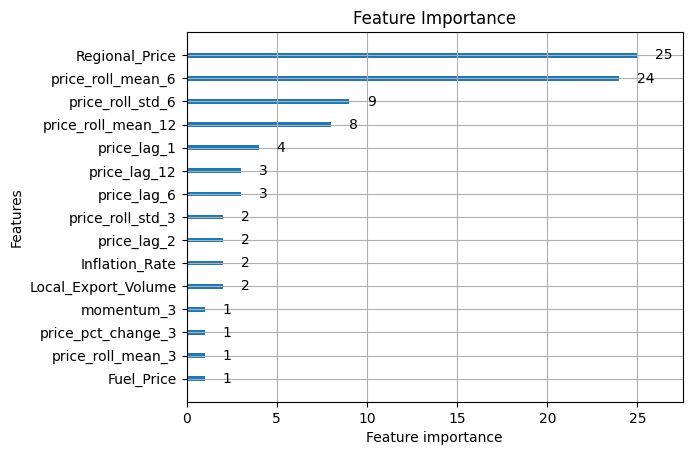

In [22]:
lgb.plot_importance(final_model, max_num_features=15)
plt.title("Feature Importance")
plt.show()